# Analyzing Hotels reviews using sophisticated sentiment analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import math
import ai21
import requests
import ast
from langdetect import detect

### API keys
Note that we use two APIs throughout this notebook, hence two different keys are required. How you can get them?

**RapidAPI key**: create a free account at [RapidAPI](https://rapidapi.com/hub).

**AI21 Studio**: create a free account at [AI21 Studio](https://studio.ai21.com). You can see you API key in the *Account* tab.

In [2]:
RAPID_API_KEY = ""
ai21.api_key = ""

## Connect to Hotels API and collect reviews

Note that this is v2 of the hotels.com API
Collecting the reviews involved:
- Converting the slug (what you see in the URL) to an internal ID
- Collecting reviews based on the ID

In [3]:
GET_ID_URL = "https://hotels-com-provider.p.rapidapi.com/v2/meta/convert/slug-id"
GET_REVIEWS_URL = "https://hotels-com-provider.p.rapidapi.com/v2/hotels/reviews/list"

def get_hotel_id_from_slug(hotel_slug):

    querystring = {"slug": hotel_slug}

    headers = {
        "X-RapidAPI-Key": RAPID_API_KEY,
        "X-RapidAPI-Host": "hotels-com-provider.p.rapidapi.com"
    }

    response = requests.request("GET", GET_ID_URL, headers=headers, params=querystring)
    return response.json()['data']


def get_hotel_reviews_page(hotel_id, page_number):
    params = {
        "locale": "en_US",
        "domain": "US",
        "hotel_id": hotel_id, 
        "page_number": str(page_number)
    }
    headers = {
        "X-RapidAPI-Key": RAPID_API_KEY,
        "X-RapidAPI-Host": "hotels-com-provider.p.rapidapi.com"
    }
    response = requests.get(url=GET_REVIEWS_URL, headers=headers, params=params)
     
    reviews = [
        review['text'] 
        for review in response.json()['reviewInfo']['reviews']
    ]
    return reviews


def get_hotel_reviews(hotel_slug, num_pages):
    hotel_id = get_hotel_id_from_slug(hotel_slug)
    all_reviews = sum(
        [get_hotel_reviews_page(hotel_id, page_number) for page_number in range(1, num_pages + 1)],
        start=[]
    )
    return all_reviews

In [4]:
# This is the hotel: https://www.hotels.com/ho125729/?locale=en_IL&pos=HCOM_IL&siteid=300000016

reviews = get_hotel_reviews(hotel_slug=125729, num_pages=70)

In [5]:
print(len(reviews))

700


## Pre-Process the reviews

Filter reviews which are too short or not in English

In [6]:
def print_list(lis):
    for item in lis:
        print(item)
        print("===========================")

In [7]:
# Look at them
print_list(reviews[:20])


Great staff wonderful location. Will stay there again! 

The Lobby was beautiful and the Hotel staff very nice. The room was clean and decorated nicely. The bathroom, however, was in need of updating-the cabinet door under the sink was falling off, the paint was chipping and tiles outdated. Also very small.
The room smelled of popcorn.
Very off putting

Besides the location, there is nothing good about this place. (1) The room is stuffy and hot (80 degree and the thermo control is a joke).  (2) extremely small room, I bumped my elbow to the sink every time I was in the bathroom (3) the room is so noisy (right next to an exhaustion fan) I had to wear ear plugs to sleep (barely sleep). (4) staff are rude and only care about the money.  All standard curtesy from other hotels are charged by this place.  Want to have one hour late checkout? pay more;  want to get to your room earlier when it is available, pay more.   I couldn't get out of there sooner.  
Room was extremely small, much smal

In [8]:
def filter_reviews(reviews):
    en_reviews = [review for review in reviews if len(review)>=20 and detect(review)=="en"]
            
    return en_reviews

In [9]:
en_reviews = filter_reviews(reviews)

print(len(en_reviews))

432


In [10]:
print_list(en_reviews[:20])

Great staff wonderful location. Will stay there again! 
The Lobby was beautiful and the Hotel staff very nice. The room was clean and decorated nicely. The bathroom, however, was in need of updating-the cabinet door under the sink was falling off, the paint was chipping and tiles outdated. Also very small.
The room smelled of popcorn.
Very off putting
Besides the location, there is nothing good about this place. (1) The room is stuffy and hot (80 degree and the thermo control is a joke).  (2) extremely small room, I bumped my elbow to the sink every time I was in the bathroom (3) the room is so noisy (right next to an exhaustion fan) I had to wear ear plugs to sleep (barely sleep). (4) staff are rude and only care about the money.  All standard curtesy from other hotels are charged by this place.  Want to have one hour late checkout? pay more;  want to get to your room earlier when it is available, pay more.   I couldn't get out of there sooner.  
Room was extremely small, much smaller

## Find the sentiments for each reviews using AI21 Studio
### Building a prompt - annotating few examples
### Sending completion request to one of Jurassic-2 models

The structure of the prompt will be in the following:

Review:

Extracted sentiment:
    
<json format, where each key is a field and the values are Positive/Negative>

See the prompt in the [playground](https://studio.ai21.com/playground?promptShare=2beb29f3-0e66-4d95-9df7-155bde01fc37)

#### Creating few-shot prompt
- Annotate several examples by yourself (in this case - load annotations done by us)
- Write a function that creates a single example
- Use both to create a few-shot prompt for a new review

In [11]:
with open("hotels_sentimented.jsonl", "r") as fp:
    EXAMPLES_DATA = json.load(fp)

In [12]:
def make_single_example(review, sentiment):   
    example = "Review:\n"
    example += review
    example += "\n"
    example += "Extracted sentiment:\n"
    example += sentiment
    
    return example

SEPARATOR = "\n##\n"

FEW_SHOT_PREFIX = SEPARATOR.join(
    make_single_example(x['review'], json.dumps(x['sentiment'])) for x in EXAMPLES_DATA
)

In [13]:
def create_review_analysis_prompt(review):
    """
    Create a few-shot prompt to analysis reviews with Jurassic-2 
    The prompt contains a preset sequence of examples followed by the query review
    """
    return FEW_SHOT_PREFIX + SEPARATOR + make_single_example(review, '')  # keep the setniment blank and let the model generate

### Perform the analysis

In [14]:
sentiments = []
for review in tqdm(en_reviews):
    prompt = create_review_analysis_prompt(review.strip())
  
    response = ai21.Completion.execute(
                                        model="j2-ultra",
                                        prompt=prompt,
                                        maxTokens=100,
                                        stopSequences=["##"]
                                        )


    sentiments.append(response['completions'][0]['data']['text'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 432/432 [21:38<00:00,  3.01s/it]


In [15]:
len(sentiments)

432

## (Experimental) Sample a random review and check the results

In [16]:
i = 123
print(en_reviews[i])
print(sentiments[i])

The Empire is a great property for a short stay, very convenient, lots of great restaurants nearby.  We have stayed here before, this time we got a VERY small room (a standard queen) that would have been better for only one person.  Next time we would spend the bucks for some more space.  Overall, one of the best values in Manhattan.  They still have daily maid service, which was a pleasant surprise.
{"Location": "Positive", "Room Quality": "Positive"}



## Create the dashboard

In [22]:
def get_topK_categories_and_score(sentiments, k=7):
    """
        Given a list of sentiments and number of top categories, create data for dashboard

        Arguments:
        - sentiments       : list of sentiments, each in json format
        - k                : how many categories to return

        Returns:
        - category_names   : the scores each category can get (in this case, Positive and Negative)
        - scores           : dict,
                             each key is a category
                             each value
    """

    parsed_sentiments = []
    for sentiment in sentiments:
        try:
            parsed_sentiments.append(ast.literal_eval(sentiment))
        except SyntaxError or ValueError:
            pass
    
    df = pd.DataFrame(parsed_sentiments)

    # extract the K categories with the most reviews    
    keys = df.count().sort_values(ascending=False)[:k].index.tolist()
    
    category_names = ['Negative', 'Positive']
    scores = {}

    for key in keys:
        scores[key] = [(df[key] == category_names[0]).sum(), (df[key] == category_names[1]).sum()]
        
    return scores, category_names

In [23]:
scores, category_names = get_topK_categories_and_score(sentiments, k=7)

In [24]:
def plot_dashboard(scores, category_names):
    # Based on: https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py
    """
    Parameters
    ----------
    scores         : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = list(scores.keys())
    data = np.array(list(scores.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        if i == 0:
            starts = -data_cum[:, i]
        else:
            starts = data_cum[:, i] - data_cum[:, i]
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    # Find the range
    max_range = math.ceil(max(sum(scores.values(), [])) / 10)*10
    
    ax.set_xlim(-max_range, max_range)
    ax.set_xticks(np.arange(-max_range, max_range+1, round(max_range // 10, -1)))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')
    
    plt.title("Empire Hotel - Reviews Dashboard")

    return fig, ax

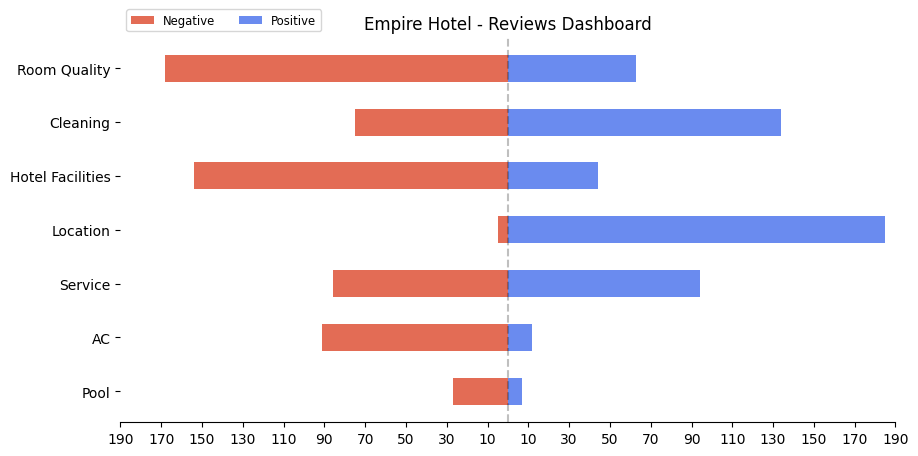

In [25]:
fig, ax = plot_dashboard(scores, category_names)
plt.show()